In [2]:
# numba>=0.51.2
# llvmlite>=0.34.0
# pynndescent

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import notebook
import torch.nn.functional as F
from pathlib import Path
import requests
import pickle
import gzip
from umap_loss import ConstructUMAPGraph, UMAPLoss
from utils import UMAPDataset

In [13]:
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


In [5]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


In [6]:
x = x_train.reshape((50000, 1, 28, 28)).astype('float32')

In [7]:
x_test = x_valid.reshape((10000, 1, 28, 28)).astype('float32')

# Define simple convolutional encoder

In [8]:
class Encoder(nn.Module):

    def __init__ (self, output_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128*6*6, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        return x


In [10]:
# construct graph of nearest neighbors
graph_constructor =  ConstructUMAPGraph(metric='euclidean', n_neighbors=15, batch_size=1000, random_state=42)

In [11]:
epochs_per_sample, head, tail, weight = graph_constructor(x)

Fri Nov 13 20:50:54 2020 Building RP forest with 16 trees
Fri Nov 13 20:50:55 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16


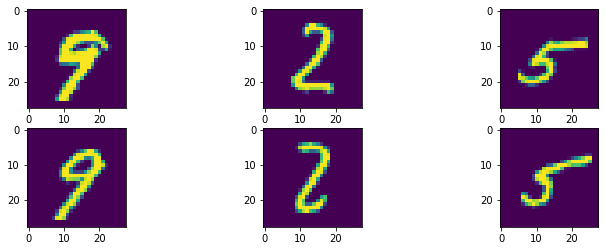

In [23]:
# plot examples of nearest neighbors
fig, ax = plt.subplots(2,3,figsize=(12,4))
ids = np.random.randint(0, len(x), size=3)
for j in range(3):
    ax[0][j].imshow(x[head[ids[j]],0,:,:])
    ax[1][j].imshow(x[tail[ids[j]],0,:,:])

In [29]:
dataset = UMAPDataset(x, epochs_per_sample, head, tail, weight, device='cuda', batch_size=1000)

In [30]:
criterion = UMAPLoss(device='cuda', min_dist=0.1, batch_size=1000, negative_sample_rate=5,
        edge_weight=None, repulsion_strength=1.0)

# train encoder

In [31]:
model = Encoder(output_dim=2).cuda()

In [50]:
print(model)

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten()
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
)


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
train_losses = []
for epoch in range(20):
    train_loss = 0.
    for batch_to, batch_from in notebook.tqdm(dataset.get_batches()):
        optimizer.zero_grad()
        embedding_to = model(batch_to)
        embedding_from = model(batch_from)
        loss = criterion(embedding_to, embedding_from)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss)
    print('epoch: {}, loss: {}'.format(epoch, train_loss))



epoch: 0, loss: 259.7646308988333



epoch: 1, loss: 189.4861028045416



epoch: 2, loss: 174.30438259243965



epoch: 3, loss: 166.04596073180437



epoch: 4, loss: 161.3044751882553



epoch: 5, loss: 157.3082993030548



epoch: 6, loss: 154.69951975345612



epoch: 7, loss: 152.6092692911625



epoch: 8, loss: 150.62153822928667



epoch: 9, loss: 148.65688917040825



epoch: 10, loss: 147.5490241870284



epoch: 11, loss: 146.03673738986254



epoch: 12, loss: 145.42237919569016



epoch: 13, loss: 144.22043084353209



epoch: 14, loss: 143.66720267385244



epoch: 15, loss: 143.1174531057477



epoch: 16, loss: 142.45208252221346



epoch: 17, loss: 142.09316092729568



epoch: 18, loss: 142.03604984283447



epoch: 19, loss: 141.1639752164483


In [48]:
torch.save(model.state_dict(), 'encoder_weights.pt') 

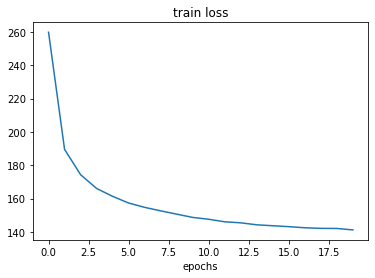

In [44]:
plt.plot(train_losses)
plt.xlabel('epochs')
plt.title('train loss')
plt.show()

In [49]:
model = Encoder(output_dim=2).cuda()
model.load_state_dict(torch.load('encoder_weights.pt'))

<All keys matched successfully>

In [35]:
from torch.utils.data import DataLoader, TensorDataset

In [37]:
test_loader = DataLoader(TensorDataset(torch.Tensor(x), torch.Tensor(x)), batch_size=256, shuffle=False)

In [38]:
outputs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x.cuda()).detach().cpu().numpy()
        outputs.append(output)
outputs = np.concatenate(outputs, axis=0)

In [39]:
outputs.shape

(50000, 2)

# Plot embedding

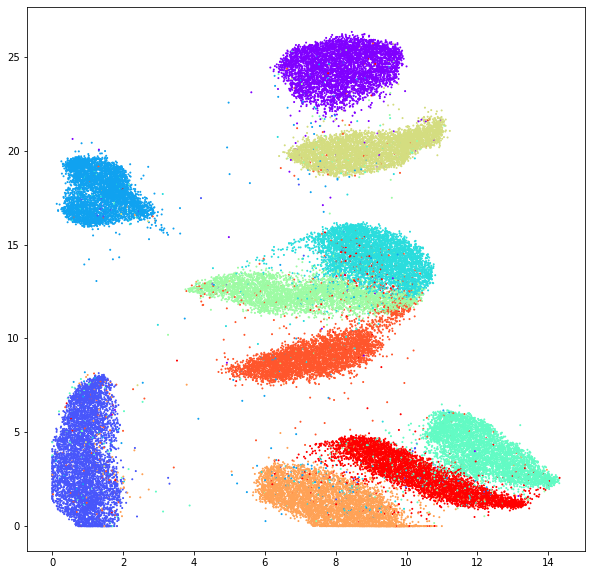

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(outputs[:,0], outputs[:,1], s=1, c=y_train, cmap='rainbow')
plt.show()